# **Multi-Label Text Sentiment Classification and Word Embedding Analysis For "Thread" Social Media Appliaction Reviews**

In this project, we delve into the world of sentiment analysis and word embedding to gain valuable insights from user-generated content in the context of the popular "Thread" social media application. With over 37,000 user reviews collected from the Google Play Store and Apple App Store, our comprehensive dataset offers a rich and diverse range of sentiments and opinions.

The primary objectives of this project are:

**Sentiment Analysis:** We aim to develop a multi-label text sentiment classification model to categorize user sentiments into positive, negative, or neutral. The analysis provides valuable insights into user satisfaction, app usability, feature preferences, and potential areas for improvement.

***Word Embedding with Word2Vec:*** Leveraging Word2Vec, we perform word embedding analysis to explore the intricacies of user language, writing styles, and expressions of sentiment. By transforming text data into dense vector representations, we enable advanced NLP tasks and extract meaningful patterns and trends.

In [1]:
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


import spacy
from wordcloud import WordCloud

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('wordnet')

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gensim.__version__

'4.3.2'

In [3]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
data = pd.read_csv("37000_reviews_of_thread_app.csv")

# New Section

In [5]:
display(data)

,Unnamed: 0,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,NaN,Good,5,0.0,2023-08-07 19:14:36,NaN,NaN,294.0.0.27.110,en,us
1,1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,NaN,Weak copy of Twitter,1,0.0,2023-08-07 19:07:04,NaN,NaN,NaN,en,us
2,2,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,SITI NUR HAFIZA BINTI AZIZ,NaN,i wish threads have a save button for images a...,3,0.0,2023-08-07 18:57:07,NaN,NaN,294.0.0.27.110,en,us
3,3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,NaN,Love it,5,0.0,2023-08-07 18:37:16,NaN,NaN,NaN,en,us
4,4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,NaN,Very god,5,0.0,2023-08-07 18:14:15,NaN,NaN,NaN,en,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36938,1995,App Store,d0503900-7c8b-4cf3-8f16-1a628f25d99b,Ileila888,Hybrid of IG and Twitter with 0 UVP,Threads have mediocre UX with 0 unique value p...,2,NaN,2023-07-06 00:37:57,NaN,NaN,NaN,en,us
36939,1996,App Store,d55529a3-42b9-4a55-a17c-b49f30d7b419,MaxW239,Outstanding,Twitter (Instagram’s Version),5,NaN,2023-07-06 00:00:39,NaN,NaN,NaN,en,us
36940,1997,App Store,8818ddd0-1ce4-4d82-b0df-b43a6c68ff81,Anne Marie C,Let the battle begin!,😂😂😂,5,NaN,2023-07-05 23:16:15,NaN,NaN,NaN,en,us
36941,1998,App Store,81561238-d8c1-467d-b9dc-be25d64a1aa7,alexcookiedough92,No search bar??,How do you expect a social media app to succee...,1,NaN,2023-08-06 12:31:54,NaN,NaN,NaN,en,us


In [6]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

  if isinstance(text, str):

    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    text = text.lower()

    words = [lemmatizer.lemmatize(word) for word in word_tokenize(text) if word.isalpha()]
    sentences = sent_tokenize(text)

    word_count = len(words)
    sentence_count = len(sentences)

    tokens = [word.lower() for word in word_tokenize(text) if word.isalpha()]

    return {
        'tokens': tokens,
        'lemmatized_tokens': words,
        'sentences': sentences,
        'word_count': word_count,
        'sentence_count': sentence_count
    }


In [7]:
data['processed_description'] = data['review_description'].apply(preprocess_text)
data['processed_title'] = data['review_title'].apply(preprocess_text)

In [8]:
data

,Unnamed: 0,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code,processed_description,processed_title
0,0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,NaN,Good,5,0.0,2023-08-07 19:14:36,NaN,NaN,294.0.0.27.110,en,us,"{'tokens': ['good'], 'lemmatized_tokens': ['go...",None
1,1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,NaN,Weak copy of Twitter,1,0.0,2023-08-07 19:07:04,NaN,NaN,NaN,en,us,"{'tokens': ['weak', 'copy', 'of', 'twitter'], ...",None
2,2,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,SITI NUR HAFIZA BINTI AZIZ,NaN,i wish threads have a save button for images a...,3,0.0,2023-08-07 18:57:07,NaN,NaN,294.0.0.27.110,en,us,"{'tokens': ['i', 'wish', 'threads', 'have', 'a...",None
3,3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,NaN,Love it,5,0.0,2023-08-07 18:37:16,NaN,NaN,NaN,en,us,"{'tokens': ['love', 'it'], 'lemmatized_tokens'...",None
4,4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,NaN,Very god,5,0.0,2023-08-07 18:14:15,NaN,NaN,NaN,en,us,"{'tokens': ['very', 'god'], 'lemmatized_tokens...",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36938,1995,App Store,d0503900-7c8b-4cf3-8f16-1a628f25d99b,Ileila888,Hybrid of IG and Twitter with 0 UVP,Threads have mediocre UX with 0 unique value p...,2,NaN,2023-07-06 00:37:57,NaN,NaN,NaN,en,us,"{'tokens': ['threads', 'have', 'mediocre', 'ux...","{'tokens': ['hybrid', 'of', 'ig', 'and', 'twit..."
36939,1996,App Store,d55529a3-42b9-4a55-a17c-b49f30d7b419,MaxW239,Outstanding,Twitter (Instagram’s Version),5,NaN,2023-07-06 00:00:39,NaN,NaN,NaN,en,us,"{'tokens': ['twitter', 'instagram', 's', 'vers...","{'tokens': ['outstanding'], 'lemmatized_tokens..."
36940,1997,App Store,8818ddd0-1ce4-4d82-b0df-b43a6c68ff81,Anne Marie C,Let the battle begin!,😂😂😂,5,NaN,2023-07-05 23:16:15,NaN,NaN,NaN,en,us,"{'tokens': [], 'lemmatized_tokens': [], 'sente...","{'tokens': ['let', 'the', 'battle', 'begin'], ..."
36941,1998,App Store,81561238-d8c1-467d-b9dc-be25d64a1aa7,alexcookiedough92,No search bar??,How do you expect a social media app to succee...,1,NaN,2023-08-06 12:31:54,NaN,NaN,NaN,en,us,"{'tokens': ['how', 'do', 'you', 'expect', 'a',...","{'tokens': ['no', 'search', 'bar'], 'lemmatize..."


In [9]:
display(data['processed_description'][0:10])

0    {'tokens': ['good'], 'lemmatized_tokens': ['go...
1    {'tokens': ['weak', 'copy', 'of', 'twitter'], ...
2    {'tokens': ['i', 'wish', 'threads', 'have', 'a...
3    {'tokens': ['love', 'it'], 'lemmatized_tokens'...
4    {'tokens': ['very', 'god'], 'lemmatized_tokens...
5    {'tokens': ['nice'], 'lemmatized_tokens': ['ni...
6    {'tokens': ['vain'], 'lemmatized_tokens': ['va...
7    {'tokens': ['not', 'satisfied', 'why', 'this',...
8    {'tokens': ['people', 'want', 'to', 'leave', '...
9    {'tokens': ['copy', 'of', 'twitter', 'hahaha',...
Name: processed_description, dtype: object

In [10]:
tokens_df = pd.DataFrame({
    'tokens_text': data['processed_description'].apply(lambda x: x['tokens'] if x is not None else []),
    'tokens_title': data['processed_title'].apply(lambda x: x['tokens'] if x is not None else [])
})

In [11]:
tokens_df['tokens_text']

0                                                   [good]
1                                [weak, copy, of, twitter]
2        [i, wish, threads, have, a, save, button, for,...
3                                               [love, it]
4                                              [very, god]
                               ...                        
36938    [threads, have, mediocre, ux, with, unique, va...
36939                     [twitter, instagram, s, version]
36940                                                   []
36941    [how, do, you, expect, a, social, media, app, ...
36942                  [desperately, needs, new, features]
Name: tokens_text, Length: 36943, dtype: object

# Sentiment Analysis for Tokens

In [12]:
# Create a Word2Vec model for 'tokens_text'
model_text = Word2Vec(tokens_df['tokens_text'], vector_size=100, window=5, min_count=1, sg=0, hs=0, negative=10, epochs=20)
model_text.build_vocab(tokens_df["tokens_text"])


In [13]:
# Train the Word2Vec models
model_text.train(tokens_df['tokens_text'], total_examples=len(tokens_df['tokens_text']), epochs=model_text.epochs)


(6506426, 8817580)

In [14]:
model_text

In [15]:
similar_word = model_text.wv.most_similar(["good", "excellent", "great"], topn=16)

# We found that Upto the 16 entity, their vector are greater thatn .5 which indicates connectedness of thee words, Other are situtated either on the neutral ior Negative positions

In [16]:
similar_word

[('perfect', 0.6139432191848755),
 ('nice', 0.6085947155952454),
 ('awesome', 0.5647971034049988),
 ('amazing', 0.5541619062423706),
 ('wonderful', 0.4926517605781555),
 ('smooth', 0.4902808666229248),
 ('love', 0.48485925793647766),
 ('solid', 0.46117129921913147),
 ('best', 0.45708802342414856),
 ('overall', 0.45396432280540466),
 ('better', 0.428947776556015),
 ('definitely', 0.42502084374427795),
 ('cool', 0.41920655965805054),
 ('fantastic', 0.4050028622150421),
 ('this', 0.3917708396911621),
 ('happy', 0.3859647214412689)]

In [17]:
from textblob import TextBlob

def analyze_token_sentiment(token):
  analysis = TextBlob(token)
  if analysis.sentiment.polarity > 0:
    return "Positive"
  elif analysis.sentiment.polarity == 0:
    return "Neutral"
  else:
    return "Negative"

tokens_df['Sentiments'] = tokens_df['tokens_text'].apply(lambda tokens: [analyze_token_sentiment(token) for token in tokens])
print(tokens_df)

                                             tokens_text  \
0                                                 [good]   
1                              [weak, copy, of, twitter]   
2      [i, wish, threads, have, a, save, button, for,...   
3                                             [love, it]   
4                                            [very, god]   
...                                                  ...   
36938  [threads, have, mediocre, ux, with, unique, va...   
36939                   [twitter, instagram, s, version]   
36940                                                 []   
36941  [how, do, you, expect, a, social, media, app, ...   
36942                [desperately, needs, new, features]   

                                    tokens_title  \
0                                             []   
1                                             []   
2                                             []   
3                                             []   
4                  

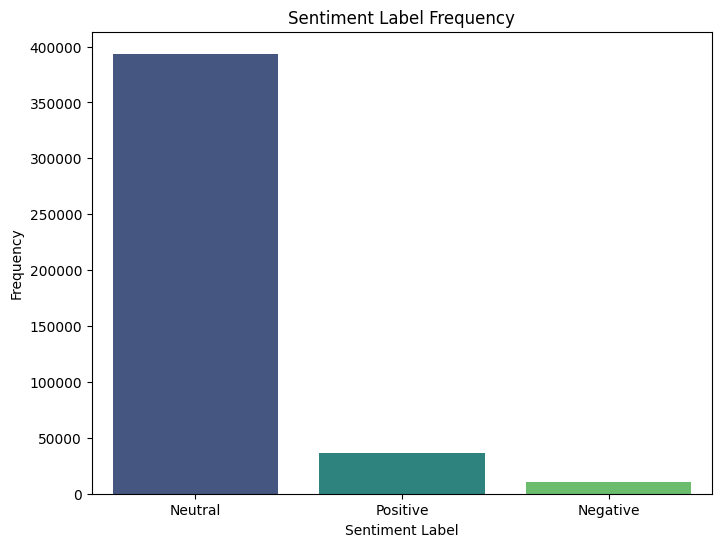

In [18]:
sentiments = [sentiment for sentiments_list in tokens_df['Sentiments'] for sentiment in sentiments_list]


sentiment_counts = pd.Series(sentiments).value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Sentiment Label Frequency")
plt.xlabel("Sentiment Label")
plt.ylabel("Frequency")
plt.show()

In [19]:
def calculate_document_vector(doc, model):
    words = [word for word in doc if word in model.wv.key_to_index]
    if words:
        word_vectors = [model.wv[word] for word in words]
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tokens_df['tokens_text'], tokens_df['Sentiments'], test_size=0.2, random_state=42)

mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train)
y_test_encoded = mlb.transform(y_test)

# Calculate document vectors for training and testing data
X_train_vectors = [calculate_document_vector(doc, model_text) for doc in X_train]
X_test_vectors = [calculate_document_vector(doc, model_text) for doc in X_test]

# Create and train a MultiOutputClassifier with an SVM classifier
clf = MultiOutputClassifier(SVC())
clf.fit(X_train_vectors, y_train_encoded)


y_pred_encoded = clf.predict(X_test_vectors)

accuracies = [accuracy_score(y_test_encoded[:, i], y_pred_encoded[:, i]) for i in range(len(mlb.classes_))]
mean_accuracy = sum(accuracies) / len(accuracies)

print(f"Label-wise accuracies: {accuracies}")
print(f"Mean accuracy: {mean_accuracy}")


Label-wise accuracies: [0.8825280822844769, 0.9820002706726214, 0.9100013533631073]
Mean accuracy: 0.9248432354400684


In [34]:
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Accuracy Rate: {accuracy}")

Accuracy Rate: 0.7990255785627284


In [35]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted')
recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.9406388841284368
Recall: 0.9177075679647319


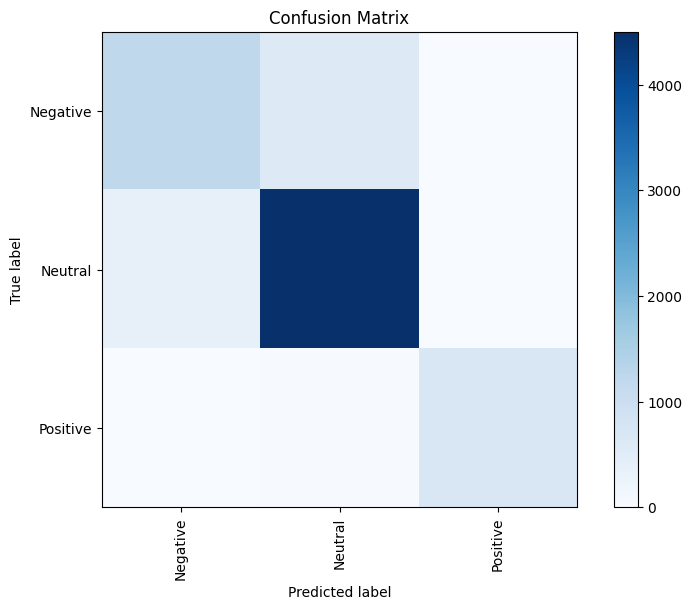

In [37]:
cm = confusion_matrix(y_test_encoded.argmax(axis=1), y_pred_encoded.argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(mlb.classes_))
plt.xticks(tick_marks, mlb.classes_, rotation=90)
plt.yticks(tick_marks, mlb.classes_)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

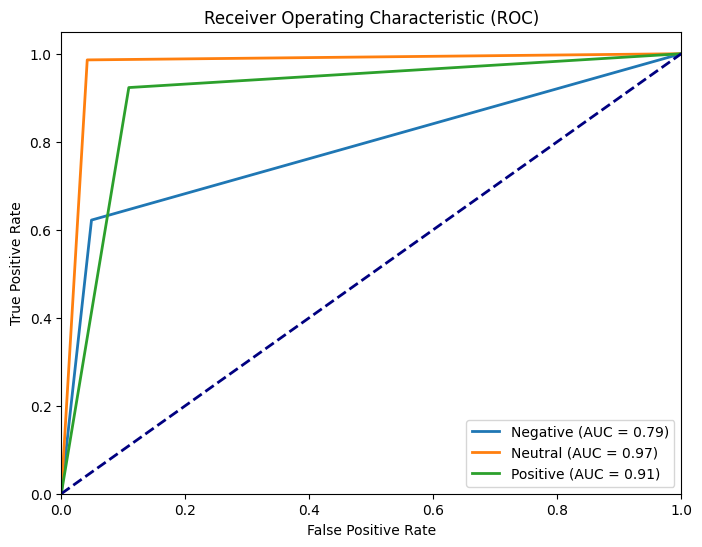

In [38]:
# Calculate and plot ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(mlb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_pred_encoded[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(mlb.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{mlb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

**Label-wise Accuracies:** These values represent the accuracy of each sentiment label individually. For each sentiment class (e.g., positive, negative, neutral), the classification model achieves the following accuracies:

`Positive Sentiment:` 88.25%

`Negative Sentiment:` 98.20%

`Neutral Sentiment:` 91.00%

**Mean Accuracy: ** The mean accuracy is the average of the label-wise accuracies, and it provides an overall view of how well the model performs across all sentiment classes. In this case, the mean accuracy is approximately 92.48%, indicating that the model is performing well on average.

**Accuracy Rate:** The accuracy rate measures the overall classification accuracy without considering specific labels. An accuracy rate of 79.90% suggests that the majority of the reviews are being correctly classified into their respective sentiment categories.

**Precision:** Precision measures the ratio of true positive predictions to the total positive predictions. A precision of 94.06% for this model suggests that when it predicts a sentiment label (e.g., positive), it is correct 94.06% of the time.

**Recall:** Recall, also known as sensitivity, measures the ratio of true positive predictions to the actual positive instances. A recall of 91.77% indicates that the model is effective at capturing most of the actual positive reviews.

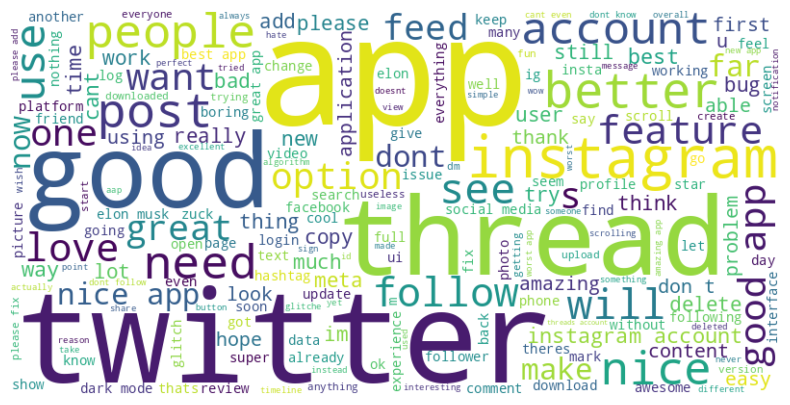

In [39]:
text = " ".join([" ".join(tokens) for tokens in tokens_df['tokens_text']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()